In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import sys
import re
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

### DL

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
# from captum.attr import IntegratedGradients

from sklearn.model_selection import KFold

# import RNA

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
device

device(type='cpu')

In [10]:
input1 = torch.load('plot/p15_input1_tensor.pt')
input2 = torch.load('plot/p15_input2_tensor.pt')
labels = torch.load('plot/p15_input_label.pt')

In [11]:
print(input1.size())
print(input2.size())
print(labels.size())

torch.Size([7447, 4, 41, 4])
torch.Size([7447, 1, 133, 133])
torch.Size([7447, 1])


In [12]:
# Custom dataset class with two inputs
class CustomDataset(Dataset):
    def __init__(self, input1, input2, labels):
        self.input1 = input1
        self.input2 = input2
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        sample = {
            'input1': self.input1[idx],
            'input2': self.input2[idx],
            'label': self.labels[idx]
        }
        return sample


In [13]:
class TwoBranchCNNRegressor(nn.Module):
    def __init__(self, input_channels1, input_channels2, output_size):
        super(TwoBranchCNNRegressor, self).__init__()

        # CNN branch for the first input
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels=input_channels1, out_channels=32, kernel_size=4, padding=(4, 4)),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=4),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, padding=(4, 4)),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=4),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, padding=(4, 4)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4),
            nn.Dropout(0.5)
        )

        # CNN branch for the second input
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels=input_channels2, out_channels=16, kernel_size=15, padding=(15, 15)),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=10),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=15, padding=(15, 15)),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=10),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=15, padding=(15, 15)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=10),
            nn.Dropout(0.5)
        )

        # Fully connected layer for merging features
        self.fc = nn.Linear(320, 64)
        
        # Regression output layer
        self.output_layer = nn.Linear(64, output_size)

    def forward(self, x1, x2):
        # Process the first input through the first CNN branch
        x1 = self.branch1(x1)
        # Process the second input through the second CNN branch
        x2 = self.branch2(x2)
        
        # Reshape the output to be compatible for concatenation
        x1 = x1.view(x1.size(0), -1)
        x2 = x2.view(x2.size(0), -1)
        
        # Dynamically calculate the size of the linear layer input again
        self.fc_input_size = x1.size(1) + x2.size(1)

        # Concatenate the features from both branches
        xmerge = torch.cat((x1, x2), dim=1)
        
        # Fully connected layer
        x = self.fc(xmerge)
        
        # Regression output layer
        output = self.output_layer(x)
        
        return output


In [9]:

y = [x for x in range(len(labels))]

# Initialize StratifiedKFold with 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

y_edit = []
y_pred = []

for fold, (train_index, val_index) in enumerate(kf.split(y)):
    print(f"\nFold {fold + 1}")

    # Split data into training and validation sets
    train_dataset1 = torch.utils.data.Subset(input1, indices=train_index)
    train_dataset2 = torch.utils.data.Subset(input2, indices=train_index)
    train_label = torch.utils.data.Subset(labels, indices=train_index)
    
    val_dataset1 = torch.utils.data.Subset(input1, indices=val_index)
    val_dataset2 = torch.utils.data.Subset(input2, indices=val_index)
    val_label = torch.utils.data.Subset(labels, indices=val_index)
    
    train_dataset = CustomDataset(input1=train_dataset1, input2=train_dataset2, labels=train_label)
    val_dataset = CustomDataset(input1=val_dataset1, input2=val_dataset2, labels=val_label)
    
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, drop_last=True)
    
    ###
    model = TwoBranchCNNRegressor(4, 1, 1)
    model.to(device)
    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model.to(device)

    num_epochs = 50
    
    for epoch in range(num_epochs):
        lst_edit = []
        lst_pred = []
        # Training
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            X1 = batch['input1'].to(device)
            X2 = batch['input2'].to(device)
            y = batch['label'].to(device)
    
            optimizer.zero_grad()
            outputs = model(X1, X2)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
    
            train_loss += loss.item() * X1.size(0)
    
        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch in val_loader:
                X1 = batch['input1'].to(device)
                X2 = batch['input2'].to(device)
                y = batch['label'].to(device)
    
                outputs = model(X1, X2)
                loss = criterion(outputs, y)
    
                val_loss += loss.item() * X1.size(0)
                
                lst_edit = lst_edit + [i[0] for i in y.tolist()]
                lst_pred = lst_pred + [i[0] for i in outputs.tolist()]
                
    
        avg_train_loss = train_loss / len(train_loader.dataset)
        avg_val_loss = val_loss / len(val_loader.dataset)
    
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")
    y_edit = y_edit + lst_edit
    y_pred = y_pred + lst_pred
    torch.save(model, 'plot/p34_CNN_model_'+str(fold)+'.pt')



Fold 1


KeyboardInterrupt: 

In [14]:
input_dataset = CustomDataset(input1=input1, input2=input2, labels=labels)
input_loader = DataLoader(input_dataset, batch_size=128, shuffle=True, drop_last=True)
###
model = torch.load('./plot/p34_CNN_model_0.pt')
model.to(device)

TwoBranchCNNRegressor(
  (branch1): Sequential(
    (0): Conv2d(4, 32, kernel_size=(4, 4), stride=(1, 1), padding=(4, 4))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1), padding=(4, 4))
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), padding=(4, 4))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.5, inplace=False)
  )
  (branch2): Sequential(
    (0): Conv2d(1, 16, kernel_size=(15, 15), stride=(1, 1), padding=(15, 15))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [15]:
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in input_loader:
        input1 = batch['input1'].to(device)
        input2 = batch['input2'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input1, input2)
        all_preds.extend(outputs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

predicted = all_preds.flatten()
true_labels = all_labels.flatten()

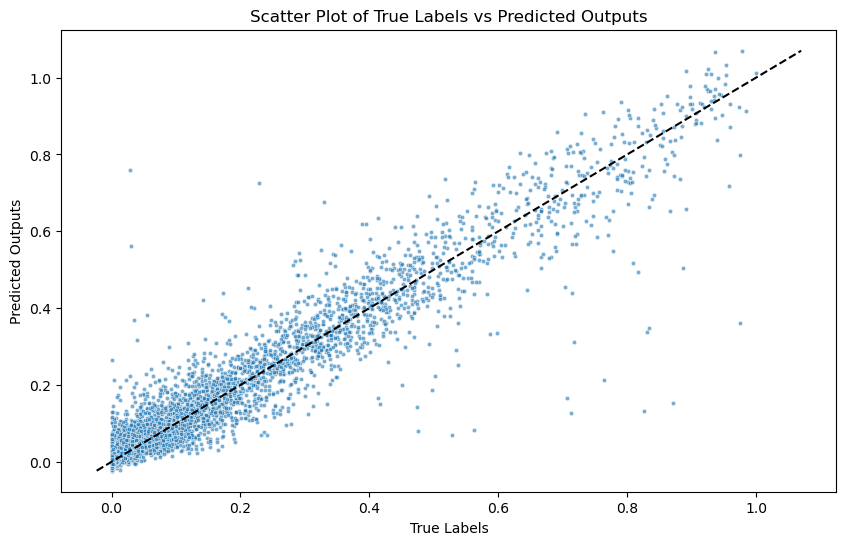

In [16]:
# Generate scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(true_labels, predicted, alpha=0.6, edgecolors='w', linewidth=0.5, s=10)
plt.xlabel('True Labels')
plt.ylabel('Predicted Outputs')
plt.title('Scatter Plot of True Labels vs Predicted Outputs')
min_val = min(true_labels.min(), predicted.min())
max_val = max(true_labels.max(), predicted.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='x=y Line') 
plt.savefig("./test1_scatterplot.png")
plt.show()


### Check Performance

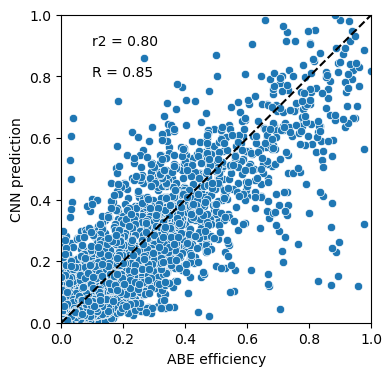

In [15]:
from sklearn.metrics import r2_score

plt.figure(figsize = (4, 4))
r1 = [i for i in y_edit]
r2 = [i for i in y_pred]
Rp = r2_score(r1, r2)
Rs = stats.spearmanr(r1, r2)[0]
plt.text(0.1, 0.9, 'r2 = %.2f' % Rp)
plt.text(0.1, 0.8, 'R = %.2f' % Rs)
plt.plot([0, 1], [0, 1], c='k', linestyle='dashed', lw=1.5)
sns.scatterplot(x = r1, y = r2)
plt.ylabel('CNN prediction')
plt.xlabel('ABE efficiency')
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.savefig('plot/p34_scatterplot_CNN_prediction.png', bbox_inches='tight', dpi=300)
plt.savefig('plot/p34_scatterplot_CNN_prediction.pdf', bbox_inches='tight', dpi=300)